In [1]:
!python /kaggle/input/isic-script-inference-effnetv1b0-f313ae/main.py /kaggle/input/isic-pytorch-training-baseline-image-only/AUROC0.5171_Loss0.3476_epoch35.bin
!mv submission.csv submission_effnetv1b0.csv

BEST_WEIGHT = /kaggle/input/isic-pytorch-training-baseline-image-only/AUROC0.5171_Loss0.3476_epoch35.bin
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


In [2]:
!python /kaggle/input/isic-script-inference-eva02/main.py /kaggle/input/isic-pytorch-training-baseline-eva02/AUROC0.5177_Loss0.2829_epoch7.bin
!mv submission.csv submission_eva02.csv

BEST_WEIGHT = /kaggle/input/isic-pytorch-training-baseline-eva02/AUROC0.5177_Loss0.2829_epoch7.bin
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


In [3]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Exploratory data analysis
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.ensemble import VotingClassifier

import lightgbm as lgb
import catboost as cb
import optuna

from tqdm.auto import tqdm
import gc

OPTIMIZE_OPTUNA = False
SUBSAMPLE = False
SUBSAMPLE_RATIO = 0.5 # only effective if SUBSAMPLE=True
DISPLAY_FEATURE_IMPORTANCE = False

In [4]:
df_eff = pd.read_csv("/kaggle/input/isic-inference-effnetv1b0-for-training-data/train_effnetv1b0.csv")
df_eff = df_eff[["target_effnetv1b0"]]
gc.collect()
df_eva = pd.read_csv("/kaggle/input/isic-inference-eva02-for-training-data/train_eva02.csv")
df_eva = df_eva[["target_eva02"]]
gc.collect()

/tmp/ipykernel_23/2806792695.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eff = pd.read_csv("/kaggle/input/isic-inference-effnetv1b0-for-training-data/train_effnetv1b0.csv")
/tmp/ipykernel_23/2806792695.py:4: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eva = pd.read_csv("/kaggle/input/isic-inference-eva02-for-training-data/train_eva02.csv")


0

In [5]:
df_train = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')
df_test  = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv')

/tmp/ipykernel_23/2493383003.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')


In [6]:
df_train.head(2)

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455


In [7]:
df_train.columns

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

In [8]:
cls_name = ['Benign','Malignant'] 
cls_count = df_train['target'].value_counts()

target
0    400666
1       393
Name: count, dtype: int64

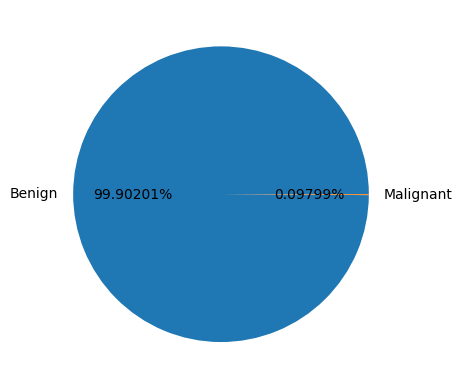

In [9]:
fig, ax = plt.subplots()
ax.pie(cls_count.values, labels=cls_name,autopct='%1.5f%%')
cls_count
#malignant -> 1

target
0    265272
1       274
Name: count, dtype: int64

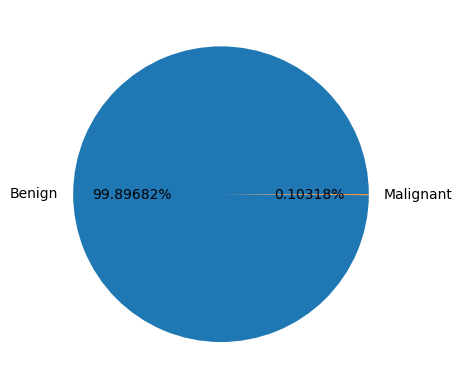

In [10]:
male_target = df_train[df_train['sex']=='male'].target.value_counts()
fig, ax = plt.subplots()
ax.pie(male_target.values, labels=cls_name,autopct='%1.5f%%')
male_target

target
0    123887
1       109
Name: count, dtype: int64

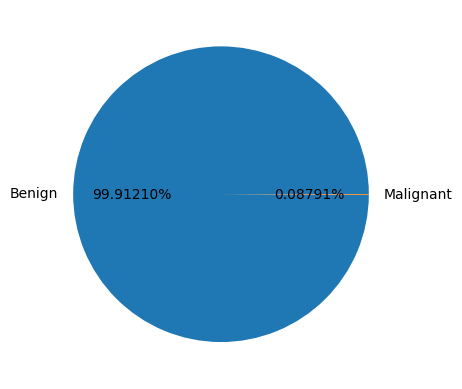

In [11]:
female_target = df_train[df_train['sex']=='female'].target.value_counts()
fig, ax = plt.subplots()
ax.pie(female_target.values, labels=cls_name,autopct='%1.5f%%')
female_target

benign age distribution

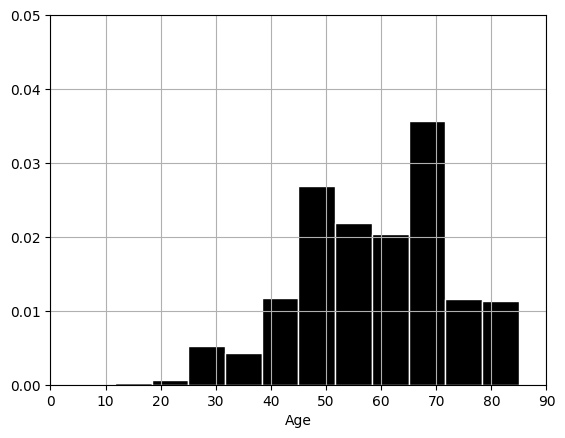

In [12]:
ymax=0.05
xmax=90
bins=12
df_train[df_train.target==0].age_approx.hist(color = 'black',  edgecolor = 'white', density=True, bins=bins)
plt.xlabel(f'Age', fontsize=10, color = 'black')
plt.ylim([0, ymax])
plt.xlim([0, xmax])
plt.show()

malignant age distribution

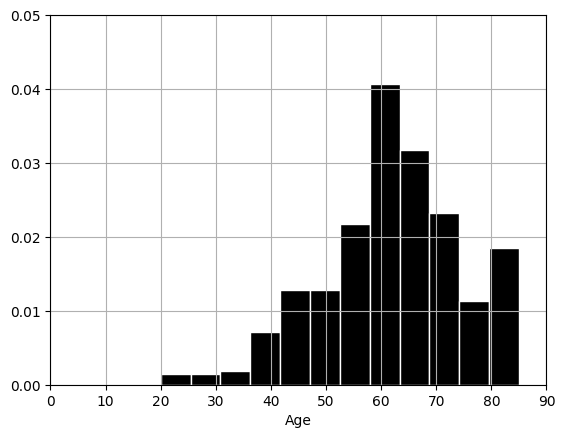

In [13]:
df_train[df_train.target==1].age_approx.hist(color = 'black',  edgecolor = 'white', density=True, bins=bins)
plt.xlabel(f'Age', fontsize=10, color = 'black')
plt.ylim([0, ymax])
plt.xlim([0, xmax])
plt.show()

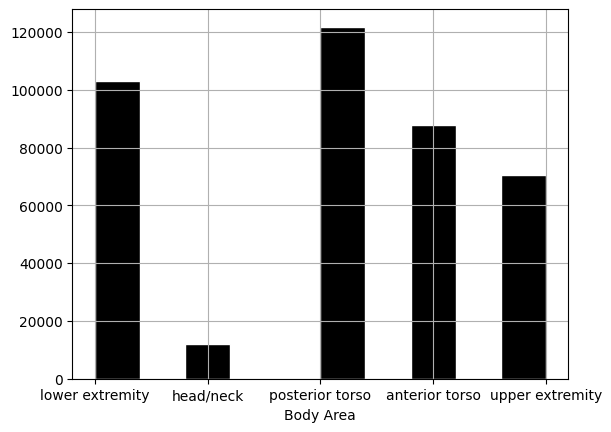

In [14]:
df_train[df_train.target==0].anatom_site_general.hist(color = 'black',  edgecolor = 'white')
plt.xlabel(f'Body Area', fontsize=10, color = 'black')
plt.show()

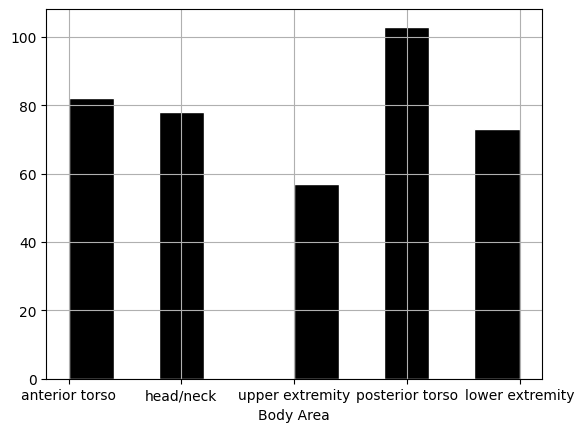

In [15]:
df_train[df_train.target==1].anatom_site_general.hist(color = 'black',  edgecolor = 'white')
plt.xlabel(f'Body Area', fontsize=10, color = 'black')
plt.show()

Missing values

In [16]:
missing_values = df_train.isnull().sum()
missing_values = missing_values[missing_values > 0 ]
missing_values

age_approx               2798
sex                     11517
anatom_site_general      5756
lesion_id              379001
iddx_2                 399991
iddx_3                 399994
iddx_4                 400508
iddx_5                 401058
mel_mitotic_index      401006
mel_thick_mm           400996
dtype: int64

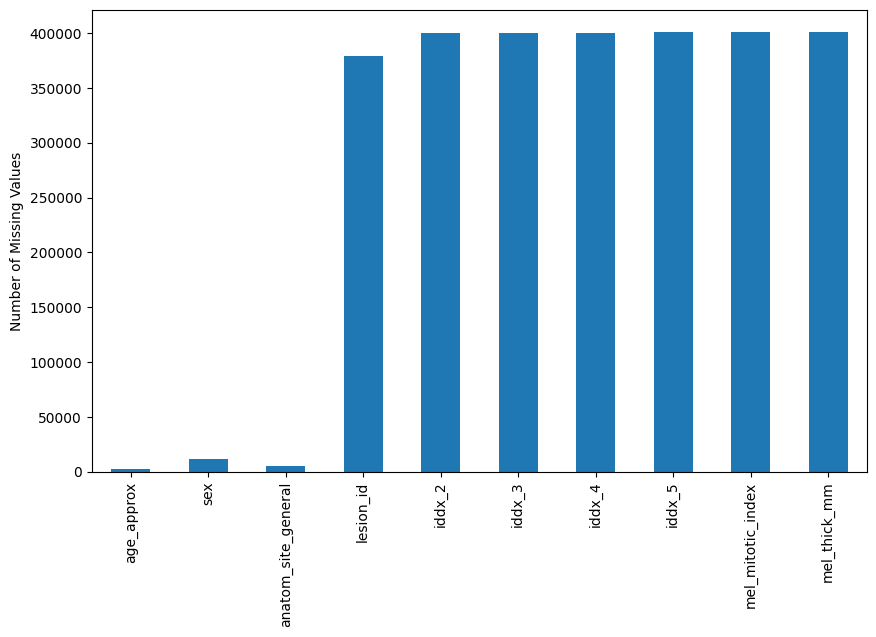

In [17]:
plt.figure(figsize=(10, 6))
missing_values.plot(kind='bar')
#plt.title('Missing Values in Training Metadata')
plt.ylabel('Number of Missing Values')
plt.show()

In [18]:
df_train.describe()

,target,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,mel_thick_mm,tbp_lv_dnn_lesion_confidence
count,401059.000000,398261.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,...,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,63.000000,4.010590e+05
mean,0.000980,58.012986,3.930827,19.974007,14.919247,28.281706,26.913015,34.786341,30.921279,54.653689,...,1.016459,2.715190,2.238605,0.306823,86.332073,-3.091862,1039.598221,55.823389,0.670952,9.716220e+01
std,0.031288,13.596165,1.743068,3.999489,3.529384,5.278676,4.482994,5.708469,4.829345,5.520849,...,0.734631,1.738165,0.623884,0.125038,52.559511,197.257995,409.819653,87.968245,0.792798,8.995782e+00
min,0.000000,5.000000,1.000000,-2.487115,-9.080269,-0.730989,9.237066,3.054228,11.846520,-1.574164,...,0.000000,0.268160,0.636247,0.052034,0.000000,-624.870728,-1052.134000,-291.890442,0.200000,1.261082e-16
25%,0.000000,50.000000,2.840000,17.330821,12.469740,24.704372,23.848125,31.003148,27.658285,51.566273,...,0.563891,1.456570,1.834745,0.211429,40.000000,-147.022125,746.519673,-8.962647,0.300000,9.966882e+01
50%,0.000000,60.000000,3.370000,19.801910,14.713930,28.171570,26.701704,34.822580,30.804893,55.035632,...,0.902281,2.186693,2.149758,0.282297,90.000000,-5.747253,1172.803000,67.957947,0.400000,9.999459e+01
75%,0.000000,70.000000,4.380000,22.304628,17.137175,31.637429,29.679913,38.430298,33.963868,58.298184,...,1.334523,3.474565,2.531443,0.382022,130.000000,140.474835,1342.131540,126.611567,0.600000,9.999996e+01
max,1.000000,85.000000,28.400000,48.189610,37.021680,54.306900,48.372700,58.765170,54.305290,105.875784,...,11.491140,17.563650,25.534791,0.977055,175.000000,614.471700,1887.766846,319.407000,5.000000,1.000000e+02


In [19]:
df_train.dtypes

isic_id                          object
target                            int64
patient_id                       object
age_approx                      float64
sex                              object
anatom_site_general              object
clin_size_long_diam_mm          float64
image_type                       object
tbp_tile_type                    object
tbp_lv_A                        float64
tbp_lv_Aext                     float64
tbp_lv_B                        float64
tbp_lv_Bext                     float64
tbp_lv_C                        float64
tbp_lv_Cext                     float64
tbp_lv_H                        float64
tbp_lv_Hext                     float64
tbp_lv_L                        float64
tbp_lv_Lext                     float64
tbp_lv_areaMM2                  float64
tbp_lv_area_perim_ratio         float64
tbp_lv_color_std_mean           float64
tbp_lv_deltaA                   float64
tbp_lv_deltaB                   float64
tbp_lv_deltaL                   float64


# Correlation Matrix

In [20]:
# Select only numeric columns for correlation matrix calculation
numeric_columns = df_train.select_dtypes(include=[np.number])
numeric_columns.head()

,target,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,0,60.0,3.04,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,...,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,NaN,97.517282
1,0,60.0,1.10,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,...,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,NaN,3.141455
2,0,60.0,3.40,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,...,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,NaN,99.804040
3,0,65.0,3.22,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,...,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,NaN,99.989998
4,0,55.0,2.73,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,...,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,NaN,70.442510


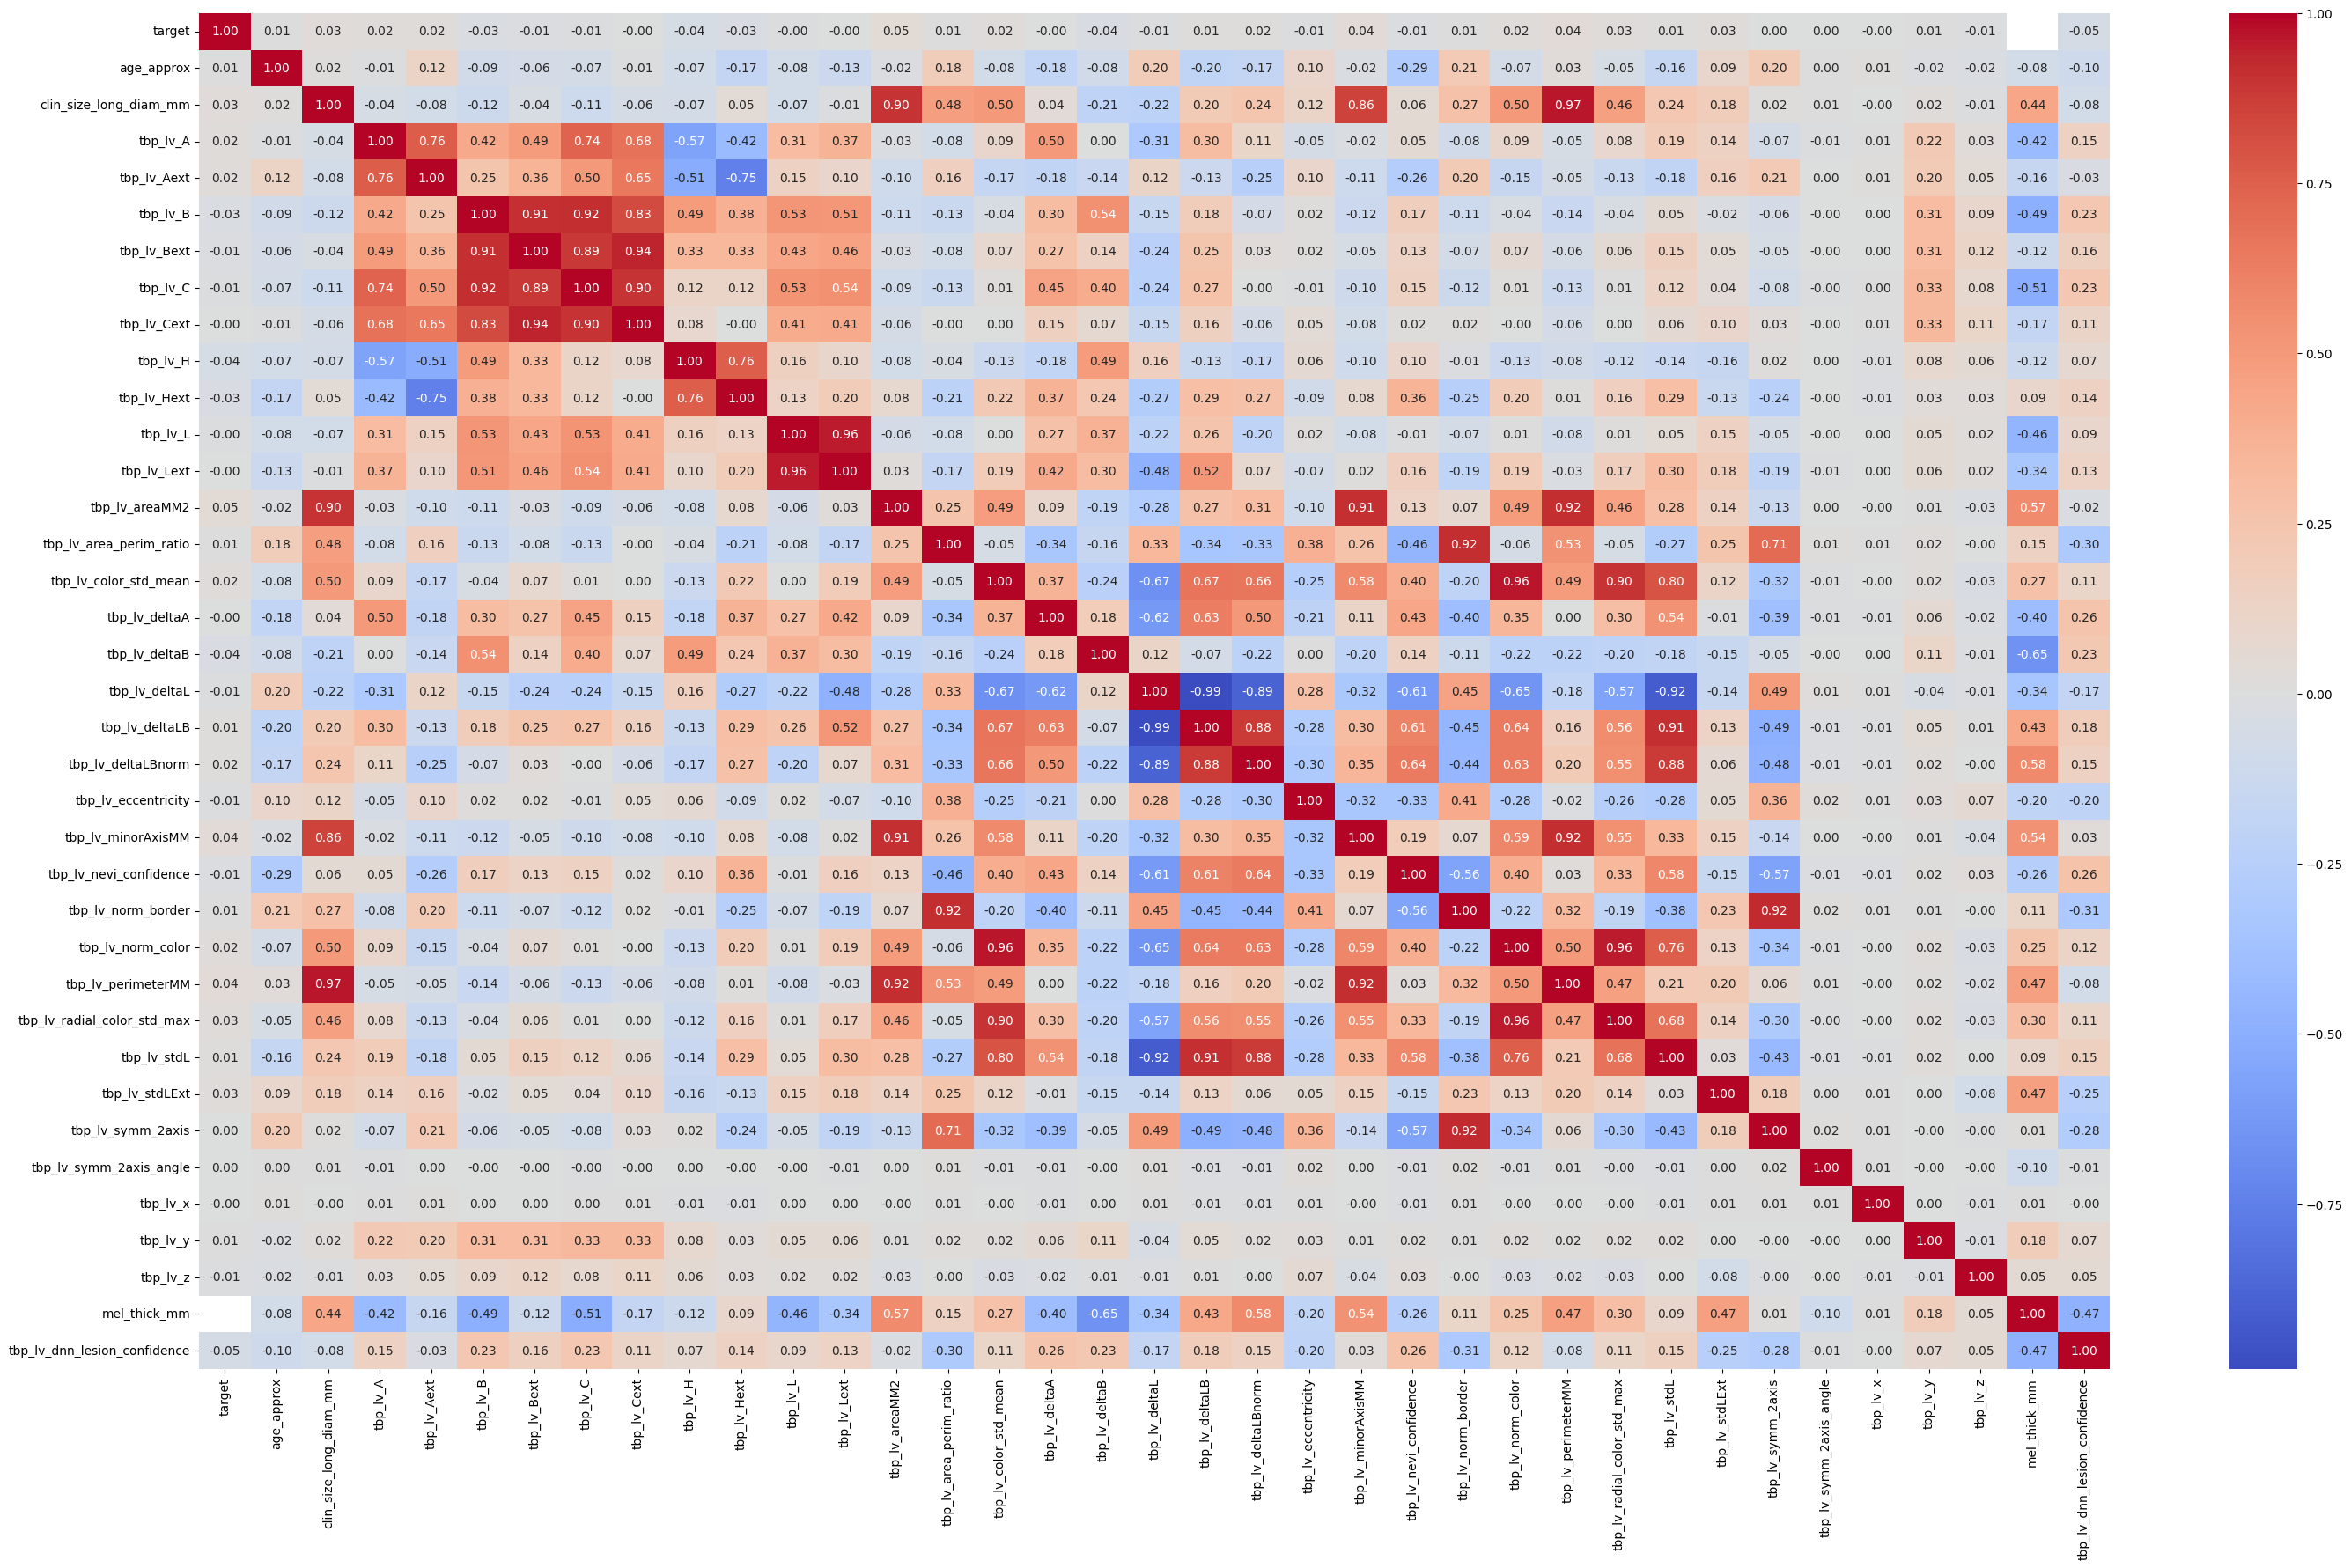

In [21]:
# Calculate correlation matrix for numerical features
correlation_matrix = numeric_columns.corr()
# Plot the heatmap of the correlation matrix
plt.figure(figsize=(35, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

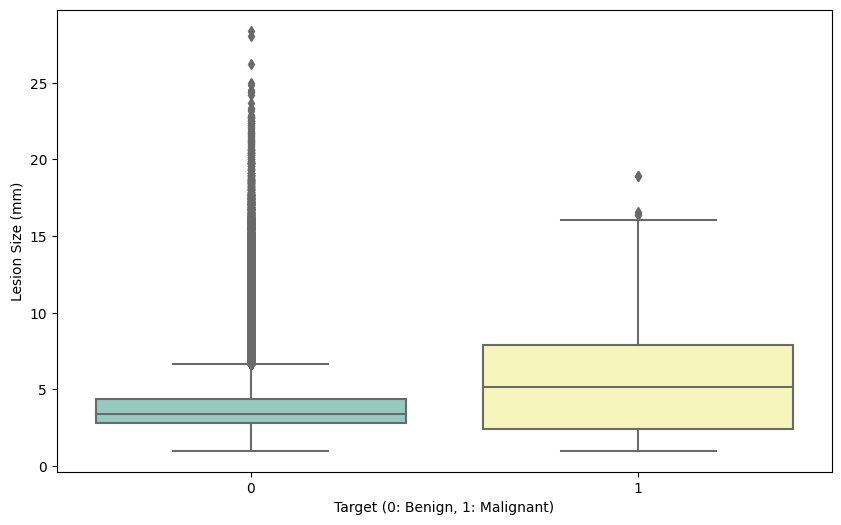

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='clin_size_long_diam_mm', data=df_train, palette='Set3')
'Lesion Size Distribution by Target Class'
plt.xlabel('Target (0: Benign, 1: Malignant)')
plt.ylabel('Lesion Size (mm)')
plt.show()

# Feature Engineering

In [23]:
def feature_engineering(df):
    # New features to try...
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)
    df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
    df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2)
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]
    df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2) 
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    df["combined_anatomical_site"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"]
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]
    
    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
    df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
    df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2) / 3)
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
    df["3d_lesion_orientation"] = np.arctan2(df_train["tbp_lv_y"], df_train["tbp_lv_x"])
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4

    new_num_cols = [
        "lesion_size_ratio", "lesion_shape_index", "hue_contrast",
        "luminance_contrast", "lesion_color_difference", "border_complexity",
        "color_uniformity", "3d_position_distance", "perimeter_to_area_ratio",
        "lesion_visibility_score", "symmetry_border_consistency", "color_consistency",

        "size_age_interaction", "hue_color_std_interaction", "lesion_severity_index", 
        "shape_complexity_index", "color_contrast_index", "log_lesion_area",
        "normalized_lesion_size", "mean_hue_difference", "std_dev_contrast",
        "color_shape_composite_index", "3d_lesion_orientation", "overall_color_difference",
        "symmetry_perimeter_interaction", "comprehensive_lesion_index",
    ]
    new_cat_cols = ["combined_anatomical_site"]
    return df, new_num_cols, new_cat_cols

In [24]:
new_train,new_num_cols,new_cat_cols = feature_engineering(df_train.copy())
num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 
    'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 
    'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 
    'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
    'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
    'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
    'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
    'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
    'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z',
] + new_num_cols
# anatom_site_general
cat_cols = ["sex", "tbp_tile_type", "tbp_lv_location", "tbp_lv_location_simple"] + new_cat_cols
train_cols = num_cols + cat_cols

new_train["target_effnetv1b0"] = df_eff["target_effnetv1b0"]
new_train["target_eva02"] = df_eva["target_eva02"]
train_cols += ["target_effnetv1b0", "target_eva02"]

category_encoder = OrdinalEncoder(
    categories='auto',
    dtype=int,
    handle_unknown='use_encoded_value',
    unknown_value=-2,
    encoded_missing_value=-1,
)

X_cat = category_encoder.fit_transform(new_train[cat_cols])
for c,cat_col in enumerate(cat_cols):
    new_train[cat_col] = X_cat[:,c]

In [25]:
new_train.dtypes

isic_id                            object
target                              int64
patient_id                         object
age_approx                        float64
sex                                 int64
                                   ...   
overall_color_difference          float64
symmetry_perimeter_interaction    float64
comprehensive_lesion_index        float64
target_effnetv1b0                 float64
target_eva02                      float64
Length: 84, dtype: object

In [26]:
gkf = GroupKFold(n_splits=5)
#gkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
if SUBSAMPLE:
    df_pos = new_train[new_train["target"] == 1]
    df_neg = new_train[new_train["target"] == 0]
    df_neg = df_neg.sample(frac=SUBSAMPLE_RATIO, random_state=42)
    new_train = pd.concat([df_pos, df_neg]).sample(frac=1.0, random_state=42).reset_index(drop=True)
new_train["fold"] = -1
for idx,(train_idx,val_idx) in enumerate(gkf.split(new_train,new_train['target'],groups=new_train['patient_id'])):
    new_train.loc[val_idx,"fold"] = idx

In [27]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc


# LightGBM

In [28]:
lgb_params = {
    'objective': 'binary',
    "random_state": 42,
    "n_estimators": 500,
    'learning_rate': 0.01,
    'bagging_freq': 1,
    'pos_bagging_fraction': 0.75,
    'neg_bagging_fraction': 0.05,
    'feature_fraction': 0.8,
    'lambda_l1': 0.8,
    'lambda_l2': 0.8,
    "verbosity": -1,
    # "extra_trees": True
}

new_params = {
    "objective": "binary",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "n_estimators": 200,
    'learning_rate': 0.05,    
    'lambda_l1': 0.0004681884533249742, 
    'lambda_l2': 8.765240856362274, 
    'num_leaves': 136, 
    'feature_fraction': 0.5392005444882538, 
    'bagging_fraction': 0.9577412548866563, 
    'bagging_freq': 6,
    'min_child_samples': 60,
    "device": "gpu"
}

scores = []
lgb_models = []
for fold in range(5):
    _df_train = new_train[new_train["fold"] != fold].reset_index(drop=True)
    _df_valid = new_train[new_train["fold"] == fold].reset_index(drop=True)
    model = lgb.LGBMRegressor(**new_params)
    #model = VotingClassifier([(f"lgb_{i}", lgb.LGBMClassifier(random_state=i, **new_params)) for i in range(3)], voting="soft")
    model.fit(_df_train[train_cols], _df_train["target"])
    preds = model.predict(_df_valid[train_cols])
    score = comp_score(_df_valid[["target"]], pd.DataFrame(preds, columns=["prediction"]), "")
    print(f"fold: {fold} - Partial AUC Score: {score:.5f}")
    scores.append(score)
    lgb_models.append(model)

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


fold: 0 - Partial AUC Score: 0.18777
fold: 1 - Partial AUC Score: 0.18335
fold: 2 - Partial AUC Score: 0.17534
fold: 3 - Partial AUC Score: 0.18654
fold: 4 - Partial AUC Score: 0.18187


In [29]:
np.mean(scores)

0.18297531470852993

# CATBOOST

In [30]:
cb_params = {
    'objective': 'Logloss',
    # "random_state": 42,
    # "colsample_bylevel": 0.3, # 0.01, 0.1
    "iterations": 400,
    "learning_rate": 0.05,
    "cat_features": cat_cols,
    "max_depth": 8,
    "l2_leaf_reg": 5,
    "task_type": "GPU",
    # "scale_pos_weight": 2,
    "verbose": 0,
}

cb_scores = []
cb_models = []
for fold in range(5):
    _df_train = new_train[new_train["fold"] != fold].reset_index(drop=True)
    _df_valid = new_train[new_train["fold"] == fold].reset_index(drop=True)
    # model = cb.CatBoostClassifier(**cb_params)
    model = VotingClassifier([(f"cb_{i}", cb.CatBoostClassifier(random_state=i, **cb_params)) for i in range(3)], voting="soft")
    # eval_set=(_df_valid[train_cols], _df_valid["target"]), early_stopping_rounds=50
    model.fit(_df_train[train_cols], _df_train["target"])
    preds = model.predict_proba(_df_valid[train_cols])[:, 1]
    score = comp_score(_df_valid[["target"]], pd.DataFrame(preds, columns=["prediction"]), "")
    print(f"fold: {fold} - Partial AUC Score: {score:.5f}")
    cb_scores.append(score)
    cb_models.append(model)

fold: 0 - Partial AUC Score: 0.18839
fold: 1 - Partial AUC Score: 0.17980
fold: 2 - Partial AUC Score: 0.17295
fold: 3 - Partial AUC Score: 0.17868
fold: 4 - Partial AUC Score: 0.18163


In [31]:
np.mean(cb_scores)

0.18028854873358097

In [32]:
"""importances = np.mean([model.feature_importances_ for model in lgb_models], 0)
df_imp = pd.DataFrame({"feature": model.feature_name_, "importance": importances}).sort_values("importance").reset_index(drop=True)"""

'importances = np.mean([model.feature_importances_ for model in lgb_models], 0)\ndf_imp = pd.DataFrame({"feature": model.feature_name_, "importance": importances}).sort_values("importance").reset_index(drop=True)'

In [33]:
"""plt.figure(figsize=(16, 12))
plt.barh(df_imp["feature"], df_imp["importance"])
plt.show()"""

'plt.figure(figsize=(16, 12))\nplt.barh(df_imp["feature"], df_imp["importance"])\nplt.show()'

# Ensembling

In [34]:
# Image features (test data)
df_eff = pd.read_csv("submission_effnetv1b0.csv")
df_test["target_effnetv1b0"] = df_eff["target"]
del df_eff
gc.collect()

df_eva = pd.read_csv("submission_eva02.csv")
df_test["target_eva02"] = df_eva["target"]
del df_eva
gc.collect()

0

In [35]:
new_df_test,_,_ = feature_engineering(df_test.copy())
X_cat = category_encoder.fit_transform(new_df_test[cat_cols])
for c, cat_col in enumerate(cat_cols):
    new_df_test[cat_col] = X_cat[:, c]

In [36]:
lgb_preds = np.mean([model.predict(new_df_test[train_cols]) for model in lgb_models], 0)
cb_preds = np.mean([model.predict(new_df_test[train_cols]) for model in cb_models], 0)
preds = 0.5*lgb_preds + 0.5*cb_preds

In [37]:
df_sub = pd.read_csv("/kaggle/input/isic-2024-challenge/sample_submission.csv")
df_sub["target"] = preds
df_sub

,isic_id,target
0,ISIC_0015657,0.000010
1,ISIC_0015729,0.000006
2,ISIC_0015740,0.000004


In [38]:
df_sub.to_csv("submission.csv", index=False)